<a href="https://colab.research.google.com/github/AkhayMenon/QOSF-Mentorship-program/blob/main/QOSF_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Quantum Error Correction using Bell-state preparation circuit in Qiskit

<font family='cursive' color='green'>*This notebook is an attempt to understand the errors that could occur in quantum circuits, and ways to correct these errors so that a desired quantum computation can be achieved.*</font>

One of the cornerstones for the development of classical computation as we know of it today was the invention of error correcting codes. The genius of Claude Shannon proposed <a href='http://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf'>a mathematical theory of communication</a> which brought in the breakthrough in understanding any information as a stream of bits (0s and 1s signifying On  or Off states of switches). This perspective gave the methodologies of quantifying the interaction of classical information with its environment. The meaning of a stream of bits can be completely changed if certain bits are flipped due to this interaction with the environment. Hence, it was necessary to find ways to ensure that random bit flips that could occur due to noise from the environment can be detected and corrected with a plausible probability. This necessity became the mother of a beautiful invention that culminated in the modern error correcting codes. 

Classical error correcting codes used the principle of encoding a bit's information in multiple bits by generating copies, and then using several clever mathematical devices to check whether an error has happened in a set of bits, and if so, where did the error occur. This information is used to flip the error bit back to its intended value. One such elegant code is the <a href='https://en.wikipedia.org/wiki/Hamming_code'>Hamming code.</a> 

Hence, it is crucial that equivalent error correcting codes have to be developed for quantum computers as well. Many great people have already worked extensively in formally developing quantum error correcting codes. It was found by <a href='https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.77.198'>Laflamme et al.</a> that perfect quantum error correcting codes (perfect codes can *deterministically* correct any arbitrary single qubit error) can be engineered based on a constraint that fixes the number of extra qubits needed to encode a logical qubit (logical qubits are an encoded version of the qubit carrying the information). 

In order to understand this constraint, let us ask the following question:
**How big should the Hilbert space of the problem be in order to accomodate the logical qubit and its subsequent error corrections?**

The errors that usually happen to the qubits are either bit flips (denoted by $\sigma_{x}$ Pauli operation), phase flips (denoted by $\sigma_{z}$ Pauli operation) or a combination of these two (denoted by $\sigma_{y} = i\sigma_{x}\sigma_{z}$ Pauli operation). The state of the initial qubit can also be unaffected (denoted by an Identity operation). It is well known that the set $\left\{ \mathbb{I},\sigma_{x},\sigma_{y},\sigma_{z}\right\}$ forms an <a href='https://quantumsim.gitlab.io/architecture/pauli.html'>orthogonal basis</a> (orthonormal with the normalising factor of $1/\sqrt{2}$). From the perspective of errors, this means that individual errors (for example bit flips) are independent and cannot be expressed as a linear combination of other errors. This also means that any arbitrary single qubit error can be expressed as a linear combination of this basis, denoting that the ability to correct single qubit bit flips and phase flips can in principle correct any arbitrary single qubit error.

Now, we need $3n+1$ subspaces ($3n$ for $\sigma_{x},\sigma_{y},\sigma_{z}$ errors and one for identity, where $n$ denotes the number of qubits) to represent one logical state. Since we need two such logical states, this becomes $2(3n+1)$. Thus we get the following contraint:
$$2(3n+1)\leq2^{n}$$
where $2^{n}$ denotes the dimension of a general Hilbert space. Several quantum error correcting codes as proposed by <a href='https://journals.aps.org/pra/abstract/10.1103/PhysRevA.52.R2493'>Shor et al.</a> and <a href='https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.77.793'>Steane et al.</a> satisfy this contraint. The minimum possible value of $n$ for which this constraint saturates was found to be $n=5$. 

We will be using $n=5$ in this notebook to demonstrate an error correction code.

In [1]:
# Let us import the reqiured libraries

import numpy as np
import random
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex

<a href='https://qiskit.org/documentation/'>Qiskit</a> is an excellent choice for designing and developing quantum circuits. In this notebook, we will use qiskit as an accompaniment to understand more about error correction. Qiskit has various simulators available for understanding the dynamics of qubit evolution. In this notebook, we will be using two such simulators available in qiskit as the backend, which are *qasm_simulator* and *statevector_simulator*.

*qasm_simulator* : Noisy quantum circuit simulator backend

*statevector_simulator* : Ideal quantum circuit statevector simulator

Let us define these backends now, so that they can be used freely throughout the code.

In [2]:
qasm = Aer.get_backend('qasm_simulator')
svec = Aer.get_backend('statevector_simulator')

## A simple Bell state generation circuit

First of all, let us make a quantum circuit that prepares the two-qubit entangled state (also known as Bell state). We use this as the base circuit to which we would introduce bit flip and phase flip errors in random. 

In [3]:
# Function to generate the Bell state
def bell():
  # Define the quantum circuit with number of quantuma and classical registers
  # Classical registers are needed to perform measurement on quantum registers
  # By default, the qubits are prepared in |0> state.
  qc = QuantumCircuit(2, 2)

  # Hadamard operation on first qubit
  qc.h(0)
  # CNOT operation with control on first and target on second qubit
  qc.cx(0,1)

  return qc

In [4]:
# Generate the Bell state preparation circuit
qc = bell()

# Perform measurement to determine the output state
qc.measure(0,0)
qc.measure(1,1)

# Draw the quantum circuit to analyze visually
qc.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

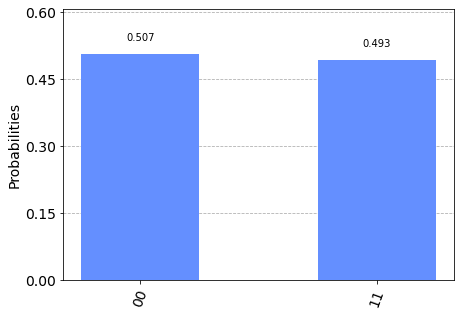

In [5]:
# Now, we execute the circuit so that final distribution after measurement is generated
# By default, the measurement is performed 1024 times
counts = execute(qc, qasm).result().get_counts()
plot_histogram(counts)

We can see that executing the circuit generated the state 
$$|\psi_{00}\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle+|11\rangle\right)$$ which is the two qubit entangled state. Executing the same circuit (without performing measurement, as measurement projets the state onto the computational basis) using the svec backend yields



In [6]:
qc = bell()
final_state = execute(qc, svec).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

Here, the basis is the set of entangled two qubit states $\left\{|00\rangle, |01\rangle,|10\rangle, |11\rangle\right\}$, which validates our result obtained through qasm backend. 

Now, let us indroduce some noise in the form of bit flips and phase flips to our bell state preparation circuit. We choose the noise based on a uniform probability distribution, so that $(2/3)^{rd}$ of the time an error occurs (either a bit flip or a phase flip) and $(1/3)^{rd}$ of the time the state doesn't change (identity operation). We will define a function that introduces random errors in the circuit.

In [7]:
def random_error(qc, seed):
  random.seed(seed) # To generate the same set of random gates
  error_list = [qc.i, qc.x, qc.z] # Identity, bit flip and phase flip errors
  random.choice(error_list)(0) # Random error in first qubit
  random.choice(error_list)(1) # Random error in second qubit
  return qc

 First of all, let us investigate whether introducing a noise (error) gate before or after the CNOT operation in the Bell state preparation circuit actually has an effect on the final state. For this, we modify our *bell* function

In [8]:
# Function to generate the Bell state with error gates
def bell(position, error=False, seed=42):
  qc = QuantumCircuit(2, 2)

  # Hadamard operation on first qubit
  qc.h(0)
  qc.barrier() # For visual differentiation of gate layers

  # Introduce error before the CNOT
  if error==True and position=='before':
      qc = random_error(qc, seed)
      qc.barrier()
  # CNOT operation with control on first and target on second qubit
  qc.cx(0,1)

  # Introduce error after the CNOT
  if error==True and position=='after':
      qc.barrier()
      qc = random_error(qc, seed)

  return qc

In [9]:
qc1 = bell(position='before', error=True)
qc1.draw()

┌───┐ ░ ┌───┐ ░      
q_0: ┤ H ├─░─┤ Z ├─░───■──
     └───┘ ░ ├───┤ ░ ┌─┴─┐
q_1: ──────░─┤ I ├─░─┤ X ├
           ░ └───┘ ░ └───┘
c: 2/═════════════════════

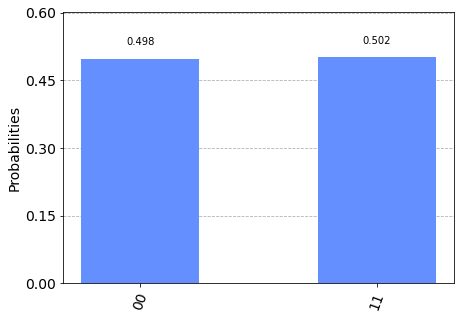

In [10]:
qc1.measure(0,0)
qc1.measure(1,1)
counts = execute(qc1, qasm).result().get_counts()
plot_histogram(counts)

In [11]:
qc1 = bell(position='before', error=True)
final_state = execute(qc1, svec).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

In [12]:
qc2 = bell(position='after', error=True)
qc2.draw()

┌───┐ ░       ░ ┌───┐
q_0: ┤ H ├─░───■───░─┤ Z ├
     └───┘ ░ ┌─┴─┐ ░ ├───┤
q_1: ──────░─┤ X ├─░─┤ I ├
           ░ └───┘ ░ └───┘
c: 2/═════════════════════

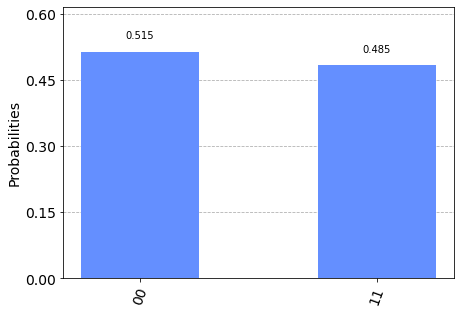

In [13]:
qc2.measure(0,0)
qc2.measure(1,1)
counts = execute(qc2, qasm).result().get_counts()
plot_histogram(counts)

In [14]:
qc2 = bell(position='after', error=True)
final_state = execute(qc2, svec).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

Now, let us try using a different seed.

In [15]:
qc1 = bell(position='before', error=True, seed = 45)
qc1.draw()

┌───┐ ░ ┌───┐ ░      
q_0: ┤ H ├─░─┤ X ├─░───■──
     └───┘ ░ ├───┤ ░ ┌─┴─┐
q_1: ──────░─┤ X ├─░─┤ X ├
           ░ └───┘ ░ └───┘
c: 2/═════════════════════

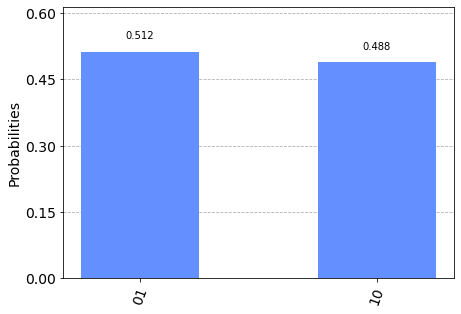

In [16]:
qc1.measure(0,0)
qc1.measure(1,1)
counts = execute(qc1, qasm).result().get_counts()
plot_histogram(counts)

In [17]:
qc1 = bell(position='before', error=True, seed = 45)
final_state = execute(qc1, svec).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

In [18]:
qc2 = bell(position='after', error=True, seed = 45)
qc2.draw()

┌───┐ ░       ░ ┌───┐
q_0: ┤ H ├─░───■───░─┤ X ├
     └───┘ ░ ┌─┴─┐ ░ ├───┤
q_1: ──────░─┤ X ├─░─┤ X ├
           ░ └───┘ ░ └───┘
c: 2/═════════════════════

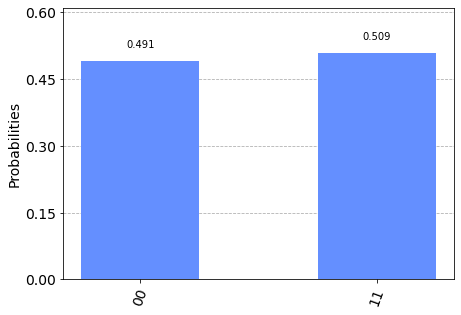

In [19]:
qc2.measure(0,0)
qc2.measure(1,1)
counts = execute(qc2, qasm).result().get_counts()
plot_histogram(counts)

In [20]:
qc2 = bell(position='after', error=True, seed = 45)
final_state = execute(qc2, svec).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector = }")

<IPython.core.display.Math object>

From these examples, we see that the order of introducing error gates matter for the case of bit flips, as it completely alters the final state conditioned on whether the errors were introduced before or after the CNOT gate. However, the order of phase flips are not as important as the bit flips. 

For our implementation of the error correcting code, we will consider the case where errors are introduced randomly and independently for each qubits **before** the CNOT operation. Before that, we need to make a small change in the function *random_error* so that seed value can be made global and not local. This is necessary to generate different set of random gates each time we introduce an error. 

In [21]:
def random_error(qc):
  error_list = [qc.i, qc.x, qc.z] # Identity, bit flip and phase flip errors
  random.choice(error_list)(0) # Random error in first qubit
  random.choice(error_list)(1) # Random error in second qubit
  return qc

The function *bell* also can be made simpler

In [22]:
# Function to generate the Bell state with error gates before CNOT
def bell():
  qc = QuantumCircuit(2, 2)

  # Hadamard operation on first qubit
  qc.h(0)
  qc.barrier()

  # Introduce error before the CNOT
  qc = random_error(qc)
  qc.barrier()

  # CNOT operation with control on first and target on second qubit
  qc.cx(0,1)

  return qc

In [23]:
random.seed(47)
circuits = []
for i in range(10):
  qc = bell()
  circuits.append(qc)
  print(qc.draw())

     ┌───┐ ░ ┌───┐ ░      
q_0: ┤ H ├─░─┤ X ├─░───■──
     └───┘ ░ ├───┤ ░ ┌─┴─┐
q_1: ──────░─┤ I ├─░─┤ X ├
           ░ └───┘ ░ └───┘
c: 2/═════════════════════
                          
     ┌───┐ ░ ┌───┐ ░      
q_0: ┤ H ├─░─┤ X ├─░───■──
     └───┘ ░ ├───┤ ░ ┌─┴─┐
q_1: ──────░─┤ Z ├─░─┤ X ├
           ░ └───┘ ░ └───┘
c: 2/═════════════════════
                          
     ┌───┐ ░ ┌───┐ ░      
q_0: ┤ H ├─░─┤ X ├─░───■──
     └───┘ ░ ├───┤ ░ ┌─┴─┐
q_1: ──────░─┤ Z ├─░─┤ X ├
           ░ └───┘ ░ └───┘
c: 2/═════════════════════
                          
     ┌───┐ ░ ┌───┐ ░      
q_0: ┤ H ├─░─┤ X ├─░───■──
     └───┘ ░ ├───┤ ░ ┌─┴─┐
q_1: ──────░─┤ X ├─░─┤ X ├
           ░ └───┘ ░ └───┘
c: 2/═════════════════════
                          
     ┌───┐ ░ ┌───┐ ░      
q_0: ┤ H ├─░─┤ Z ├─░───■──
     └───┘ ░ ├───┤ ░ ┌─┴─┐
q_1: ──────░─┤ X ├─░─┤ X ├
           ░ └───┘ ░ └───┘
c: 2/═════════════════════
                          
     ┌───┐ ░ ┌───┐ ░      
q_0: ┤ H ├─░─┤ X ├─░───■──
 

In this circuit, the first layer can be considered as the input layer which should be encoded into 5 qubits (for each qubit) using the error correcting code developed by Laflamme et al. The next layer is the noise layer, where independent random errors corrupt the initial input state (which is the 5 qubit encoded state). Right after the noise layer, we will perform a syndrome measurement using a decoding circuit that will give us information about the kind of error that has occured to the initial states. We perform the required unitary transformation after correctly identifying the error, which completes the error correction scheme. 

## Perfect quantum error correcting code

Laflamme et al. proposed a scheme in which the logical qubits denoted by $|0_{L}\rangle$ and $|1_{L}\rangle$ are encoded using 5 qubits as
$$|0_{L}\rangle = -|00000\rangle + |01111\rangle - |10011\rangle + |11100\rangle + |00110\rangle + |01001\rangle + |10101\rangle + |11010\rangle~,$$
$$|1_{L}\rangle = -|11111\rangle + |10000\rangle + |01100\rangle - |00011\rangle + |11001\rangle + |10110\rangle - |01010\rangle - |00101\rangle$$
with their normalization factors omitted for simplicity. This encoding is found from the orthogonality conditions for the different subspaces that we tried to understand earlier in this notebook. Different 5 qubit encodings can be similarly made by permuting the 5 qubits and changing their signs correspondingly. 

Let us build the circuit for encoding the states now.

In [24]:
# Function to encode the qubit to a logical qubit state

def encode(enc):

  enc.h(0)
  enc.h(1)
  enc.h(3)
  enc.barrier()

  enc.h(4)
  enc.mct([1,2,3],4)
  enc.h(4)
  enc.barrier()

  enc.x(1)
  enc.x(3)
  enc.h(4)
  enc.mct([1,2,3],4)
  enc.h(4)
  enc.x(3)
  enc.x(1)
  enc.barrier()

  enc.cx(2,4)
  enc.barrier()

  enc.cx(2,4)
  enc.cx(0,2)
  enc.cx(2,4)
  enc.barrier()

  enc.cx(3,2)
  enc.barrier()

  enc.cx(1,4)
  enc.barrier()

  enc.h(2)
  enc.ccx(4,3,2)
  enc.h(2)

  return enc

In [25]:
enc = QuantumCircuit(5,5)
enc = encode(enc)
enc.draw()

┌───┐ ░                 ░                 ░       ░                 ░ »
q_0: ┤ H ├─░─────────────────░─────────────────░───────░────────■────────░─»
     ├───┤ ░                 ░ ┌───┐     ┌───┐ ░       ░        │        ░ »
q_1: ┤ H ├─░────────■────────░─┤ X ├──■──┤ X ├─░───────░────────┼────────░─»
     └───┘ ░        │        ░ └───┘  │  └───┘ ░       ░      ┌─┴─┐      ░ »
q_2: ──────░────────■────────░────────■────────░───■───░───■──┤ X ├──■───░─»
     ┌───┐ ░        │        ░ ┌───┐  │  ┌───┐ ░   │   ░   │  └───┘  │   ░ »
q_3: ┤ H ├─░────────■────────░─┤ X ├──■──┤ X ├─░───┼───░───┼─────────┼───░─»
     └───┘ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤┌─┴─┐├───┤ ░ ┌─┴─┐ ░ ┌─┴─┐     ┌─┴─┐ ░ »
q_4: ──────░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ X ├─────┤ X ├─░─»
           ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘     └───┘ ░ »
c: 5/══════════════════════════════════════════════════════════════════════»
                                                                           »
«           ░       ░                
«q_0: ──────░───────░────────────────
«           ░       ░                
«q_1: ──────░───■───░────────────────
«     ┌───┐ ░   │   ░ ┌───┐┌───┐┌───┐
«q_2: ┤ X ├─░───┼───░─┤ H ├┤ X ├┤ H ├
«     └─┬─┘ ░   │   ░ └───┘└─┬─┘└───┘
«q_3: ──■───░───┼───░────────■───────
«           ░ ┌─┴─┐ ░        │       
«q_4: ──────░─┤ X ├─░────────■───────
«           ░ └───┘ ░                
«c: 5/═══════════════════════════════
«

This circuit encodes the general state $\alpha|0\rangle+\beta|1\rangle$ sent through the quantum register q_2 to the logical qubit states discussed above. The resulting state will thus be an arbitrary superposition of the logical qubit states denoted as $a|0_{L}\rangle+b|1_{L}\rangle$.

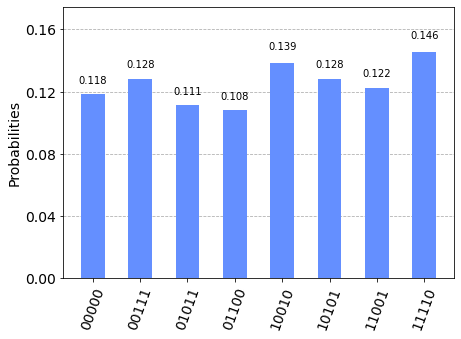

In [26]:
# Let us measure this circuit
for i in range(5):
  enc.measure(i,i)
counts = execute(enc, qasm).result().get_counts()
plot_histogram(counts)

The results in the x-axis have to be read from top to bottom due to the convention followed by qiskit. This validates the claim that the input state $|0\rangle$ is encoded as $|0_{L}\rangle$. Let us check the same for the input state $|1\rangle$. 

In [27]:
enc = QuantumCircuit(5,5)
# Input state
enc.x(2)
enc.barrier()
enc = encode(enc)
enc.draw()

░ ┌───┐ ░                 ░                 ░       ░           »
q_0: ──────░─┤ H ├─░─────────────────░─────────────────░───────░────────■──»
           ░ ├───┤ ░                 ░ ┌───┐     ┌───┐ ░       ░        │  »
q_1: ──────░─┤ H ├─░────────■────────░─┤ X ├──■──┤ X ├─░───────░────────┼──»
     ┌───┐ ░ └───┘ ░        │        ░ └───┘  │  └───┘ ░       ░      ┌─┴─┐»
q_2: ┤ X ├─░───────░────────■────────░────────■────────░───■───░───■──┤ X ├»
     └───┘ ░ ┌───┐ ░        │        ░ ┌───┐  │  ┌───┐ ░   │   ░   │  └───┘»
q_3: ──────░─┤ H ├─░────────■────────░─┤ X ├──■──┤ X ├─░───┼───░───┼───────»
           ░ └───┘ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤┌─┴─┐├───┤ ░ ┌─┴─┐ ░ ┌─┴─┐     »
q_4: ──────░───────░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ X ├─────»
           ░       ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘     »
c: 5/══════════════════════════════════════════════════════════════════════»
                                                                           »
«           ░       ░       ░                
«q_0: ──────░───────░───────░────────────────
«           ░       ░       ░                
«q_1: ──────░───────░───■───░────────────────
«           ░ ┌───┐ ░   │   ░ ┌───┐┌───┐┌───┐
«q_2: ──■───░─┤ X ├─░───┼───░─┤ H ├┤ X ├┤ H ├
«       │   ░ └─┬─┘ ░   │   ░ └───┘└─┬─┘└───┘
«q_3: ──┼───░───■───░───┼───░────────■───────
«     ┌─┴─┐ ░       ░ ┌─┴─┐ ░        │       
«q_4: ┤ X ├─░───────░─┤ X ├─░────────■───────
«     └───┘ ░       ░ └───┘ ░                
«c: 5/═══════════════════════════════════════
«

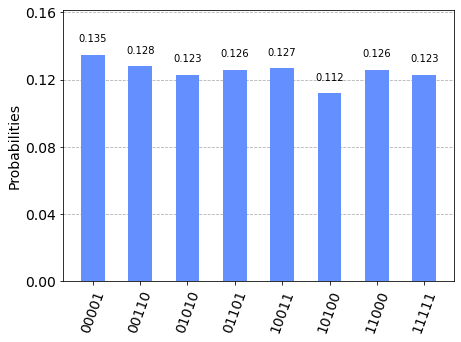

In [28]:
for i in range(5):
  enc.measure(i,i)
counts = execute(enc, qasm).result().get_counts()
plot_histogram(counts)

As expected, the state $|1\rangle$ is encoded as $|1_{L}\rangle$. Now, we come to the most interesting part of this error correcting scheme. The circuit used to correct the errors in the encoded state after noise is the same circuit used for encoding, run backwards. Running a circuit backwards is seen as a dagger operation (conjugate transpose) of the matrix of the total unitary operation performed by a circuit. 

Measuring the qubits other than q_2 in the backward circuit (decoder/error corrector) yields the syndrome of the type of error that has occured to the general state encoded. Various syndromes and related errors are summed up in the following table:

| Error | Syndrome (q_0,q_1,q_3,q_4)| Resulting state (q_2)|
| :-: | :-: | :-: |
| None | 0000 | $\alpha|0\rangle+\beta|1\rangle$ |
| BS3 | 1101 | $-\alpha|1\rangle+\beta|0\rangle$ |
| BS5 | 1111 | $-\alpha|0\rangle+\beta|1\rangle$ |
| B2 | 0001 | $\alpha|0\rangle-\beta|1\rangle$ |
| S3 | 1010 | $\alpha|0\rangle-\beta|1\rangle$ |
| S5 | 1100 | $\alpha|0\rangle-\beta|1\rangle$ |
| BS2 | 0101 | $\alpha|0\rangle-\beta|1\rangle$ |
| B5 | 0011 | $-\alpha|0\rangle-\beta|1\rangle$ |
| S1 | 1000 | $-\alpha|0\rangle-\beta|1\rangle$ |
| S2 | 0100 | $-\alpha|0\rangle-\beta|1\rangle$ |
| S4 | 0010 | $-\alpha|0\rangle-\beta|1\rangle$ |
| B1 | 0110 | $-\alpha|1\rangle-\beta|0\rangle$ |
| B3 | 0111 | $-\alpha|1\rangle-\beta|0\rangle$ |
| B4 | 1011 | $-\alpha|1\rangle-\beta|0\rangle$ |
| BS1 | 1110 | $-\alpha|1\rangle-\beta|0\rangle$ |
| BS4 | 1001 | $-\alpha|1\rangle-\beta|0\rangle$ |

Here, BSk, Sk and Bk correspond to Bit+phase flip, Phase flip and Bit flip in $k^{th}$ bit respectively. Let us encode an equal superposition of $|0\rangle$ and $|1\rangle$ using the encoder circuit, introduce random errors to the encoded state and then try to decode and correct the errors using the encoder circuit run backwards. 

In [29]:
enc = QuantumCircuit(5,4)
# Input state 
enc.h(2)
enc.barrier()
enc = encode(enc)
enc.draw()

░ ┌───┐ ░                 ░                 ░       ░           »
q_0: ──────░─┤ H ├─░─────────────────░─────────────────░───────░────────■──»
           ░ ├───┤ ░                 ░ ┌───┐     ┌───┐ ░       ░        │  »
q_1: ──────░─┤ H ├─░────────■────────░─┤ X ├──■──┤ X ├─░───────░────────┼──»
     ┌───┐ ░ └───┘ ░        │        ░ └───┘  │  └───┘ ░       ░      ┌─┴─┐»
q_2: ┤ H ├─░───────░────────■────────░────────■────────░───■───░───■──┤ X ├»
     └───┘ ░ ┌───┐ ░        │        ░ ┌───┐  │  ┌───┐ ░   │   ░   │  └───┘»
q_3: ──────░─┤ H ├─░────────■────────░─┤ X ├──■──┤ X ├─░───┼───░───┼───────»
           ░ └───┘ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤┌─┴─┐├───┤ ░ ┌─┴─┐ ░ ┌─┴─┐     »
q_4: ──────░───────░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ X ├─────»
           ░       ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘     »
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«           ░       ░       ░                
«q_0: ──────░───────░───────░────────────────
«           ░       ░       ░                
«q_1: ──────░───────░───■───░────────────────
«           ░ ┌───┐ ░   │   ░ ┌───┐┌───┐┌───┐
«q_2: ──■───░─┤ X ├─░───┼───░─┤ H ├┤ X ├┤ H ├
«       │   ░ └─┬─┘ ░   │   ░ └───┘└─┬─┘└───┘
«q_3: ──┼───░───■───░───┼───░────────■───────
«     ┌─┴─┐ ░       ░ ┌─┴─┐ ░        │       
«q_4: ┤ X ├─░───────░─┤ X ├─░────────■───────
«     └───┘ ░       ░ └───┘ ░                
«c: 4/═══════════════════════════════════════
«

We modify the *random_error* function a bit to accomodate 5 qubits, with the constraint that atmost 1 error occurs. 

In [30]:
def random_error(qc, r):
  error_list = [qc.i, qc.x, qc.z] # Identity, bit flip and phase flip errors
  random.choice(error_list)(r) # Random error in r^{th} qubit
  return qc

In [31]:
random.seed(26)
enc.barrier()
r = random.randint(0,4)
enc = random_error(enc, r)
enc.draw()

░ ┌───┐ ░                 ░                 ░       ░           »
q_0: ──────░─┤ H ├─░─────────────────░─────────────────░───────░────────■──»
           ░ ├───┤ ░                 ░ ┌───┐     ┌───┐ ░       ░        │  »
q_1: ──────░─┤ H ├─░────────■────────░─┤ X ├──■──┤ X ├─░───────░────────┼──»
     ┌───┐ ░ └───┘ ░        │        ░ └───┘  │  └───┘ ░       ░      ┌─┴─┐»
q_2: ┤ H ├─░───────░────────■────────░────────■────────░───■───░───■──┤ X ├»
     └───┘ ░ ┌───┐ ░        │        ░ ┌───┐  │  ┌───┐ ░   │   ░   │  └───┘»
q_3: ──────░─┤ H ├─░────────■────────░─┤ X ├──■──┤ X ├─░───┼───░───┼───────»
           ░ └───┘ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤┌─┴─┐├───┤ ░ ┌─┴─┐ ░ ┌─┴─┐     »
q_4: ──────░───────░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ X ├─────»
           ░       ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘     »
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«           ░       ░       ░                 ░      
«q_0: ──────░───────░───────░─────────────────░──────
«           ░       ░       ░                 ░ ┌───┐
«q_1: ──────░───────░───■───░─────────────────░─┤ Z ├
«           ░ ┌───┐ ░   │   ░ ┌───┐┌───┐┌───┐ ░ └───┘
«q_2: ──■───░─┤ X ├─░───┼───░─┤ H ├┤ X ├┤ H ├─░──────
«       │   ░ └─┬─┘ ░   │   ░ └───┘└─┬─┘└───┘ ░      
«q_3: ──┼───░───■───░───┼───░────────■────────░──────
«     ┌─┴─┐ ░       ░ ┌─┴─┐ ░        │        ░      
«q_4: ┤ X ├─░───────░─┤ X ├─░────────■────────░──────
«     └───┘ ░       ░ └───┘ ░                 ░      
«c: 4/═══════════════════════════════════════════════
«

In [32]:
# Define the error correcting circuit
def correct(enc):

  enc.h(2)
  enc.ccx(4,3,2)
  enc.h(2)
  enc.barrier()

  enc.cx(1,4)
  enc.barrier()

  enc.cx(3,2)
  enc.barrier()

  enc.cx(2,4)
  enc.cx(0,2)
  enc.cx(2,4)
  enc.barrier()

  enc.cx(2,4)
  enc.barrier()

  enc.x(1)
  enc.x(3)
  enc.h(4)
  enc.mct([1,2,3],4)
  enc.h(4)
  enc.x(3)
  enc.x(1)
  enc.barrier()

  enc.h(4)
  enc.mct([1,2,3],4)
  enc.h(4)
  enc.barrier()

  enc.h(0)
  enc.h(1)
  enc.h(3)
  enc.barrier()

  enc.measure(0,0)
  enc.measure(1,1)
  enc.measure(3,2)
  enc.measure(4,3)

  return enc

In [33]:
enc.barrier()
enc = correct(enc)
enc.draw()

░ ┌───┐ ░                 ░                 ░       ░           »
q_0: ──────░─┤ H ├─░─────────────────░─────────────────░───────░────────■──»
           ░ ├───┤ ░                 ░ ┌───┐     ┌───┐ ░       ░        │  »
q_1: ──────░─┤ H ├─░────────■────────░─┤ X ├──■──┤ X ├─░───────░────────┼──»
     ┌───┐ ░ └───┘ ░        │        ░ └───┘  │  └───┘ ░       ░      ┌─┴─┐»
q_2: ┤ H ├─░───────░────────■────────░────────■────────░───■───░───■──┤ X ├»
     └───┘ ░ ┌───┐ ░        │        ░ ┌───┐  │  ┌───┐ ░   │   ░   │  └───┘»
q_3: ──────░─┤ H ├─░────────■────────░─┤ X ├──■──┤ X ├─░───┼───░───┼───────»
           ░ └───┘ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤┌─┴─┐├───┤ ░ ┌─┴─┐ ░ ┌─┴─┐     »
q_4: ──────░───────░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ X ├─────»
           ░       ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘     »
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«           ░       ░       ░                 ░       ░                 ░      »
«q_0: ──────░───────░───────░─────────────────░───────░─────────────────░──────»
«           ░       ░       ░                 ░ ┌───┐ ░                 ░      »
«q_1: ──────░───────░───■───░─────────────────░─┤ Z ├─░─────────────────░───■──»
«           ░ ┌───┐ ░   │   ░ ┌───┐┌───┐┌───┐ ░ └───┘ ░ ┌───┐┌───┐┌───┐ ░   │  »
«q_2: ──■───░─┤ X ├─░───┼───░─┤ H ├┤ X ├┤ H ├─░───────░─┤ H ├┤ X ├┤ H ├─░───┼──»
«       │   ░ └─┬─┘ ░   │   ░ └───┘└─┬─┘└───┘ ░       ░ └───┘└─┬─┘└───┘ ░   │  »
«q_3: ──┼───░───■───░───┼───░────────■────────░───────░────────■────────░───┼──»
«     ┌─┴─┐ ░       ░ ┌─┴─┐ ░        │        ░       ░        │        ░ ┌─┴─┐»
«q_4: ┤ X ├─░───────░─┤ X ├─░────────■────────░───────░────────■────────░─┤ X ├»
«     └───┘ ░       ░ └───┘ ░                 ░       ░                 ░ └───┘»
«c: 4/═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ░       ░                 ░       ░                 ░                 ░ »
«q_0: ─░───────░────────■────────░───────░─────────────────░─────────────────░─»
«      ░       ░        │        ░       ░ ┌───┐     ┌───┐ ░                 ░ »
«q_1: ─░───────░────────┼────────░───────░─┤ X ├──■──┤ X ├─░────────■────────░─»
«      ░ ┌───┐ ░      ┌─┴─┐      ░       ░ └───┘  │  └───┘ ░        │        ░ »
«q_2: ─░─┤ X ├─░───■──┤ X ├──■───░───■───░────────■────────░────────■────────░─»
«      ░ └─┬─┘ ░   │  └───┘  │   ░   │   ░ ┌───┐  │  ┌───┐ ░        │        ░ »
«q_3: ─░───■───░───┼─────────┼───░───┼───░─┤ X ├──■──┤ X ├─░────────■────────░─»
«      ░       ░ ┌─┴─┐     ┌─┴─┐ ░ ┌─┴─┐ ░ ├───┤┌─┴─┐├───┤ ░ ┌───┐┌─┴─┐┌───┐ ░ »
«q_4: ─░───────░─┤ X ├─────┤ X ├─░─┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├─░─»
«      ░       ░ └───┘     └───┘ ░ └───┘ ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░ »
«c: 4/═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«     ┌───┐ ░ ┌─┐         
«q_0: ┤ H ├─░─┤M├─────────
«     ├───┤ ░ └╥┘┌─┐      
«q_1: ┤ H ├─░──╫─┤M├──────
«     └───┘ ░  ║ └╥┘      
«q_2: ──────░──╫──╫───────
«     ┌───┐ ░  ║  ║ ┌─┐   
«q_3: ┤ H ├─░──╫──╫─┤M├───
«     └───┘ ░  ║  ║ └╥┘┌─┐
«q_4: ──────░──╫──╫──╫─┤M├
«           ░  ║  ║  ║ └╥┘
«c: 4/═════════╩══╩══╩══╩═
«              0  1  2  3

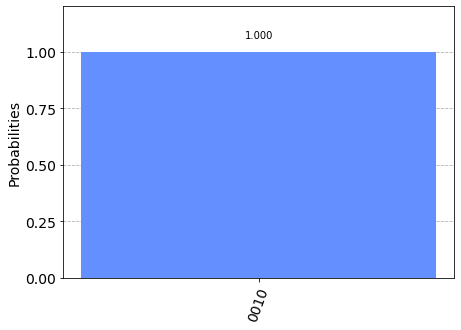

In [34]:
counts = execute(enc, qasm).result().get_counts()
plot_histogram(counts)

Looking up in the table presented above, we can immediately recognize that a phase flip error has occured in the second qubit and corresponds to the state $-\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)$. Hence, error corresponds to simultaneous phase flips in the original encoded state, which appears as a global phase $e^{i\pi}$. In quantum mechanics, global phase does not matter. Hence, we don't have to perform any correction.

Since we now know how to correct single qubit errors, we have in principle solved the problem of correcting errors in two qubits of the bell circuit. 